[{'angle': -90, 'distance': 62.45}, {'angle': -80, 'distance': 85.84}, {'angle': -70, 'distance': 86.01}, {'angle': -60, 'distance': 36.51}, {'angle': -50, 'distance': 35.54}, {'angle': -40, 'distance': 34.67}, {'angle': -30, 'distance': 34.63}, {'angle': -20, 'distance': 34.75}, {'angle': -10, 'distance': 35.63}, {'angle': 0, 'distance': 117.97}, {'angle': 10, 'distance': 34.8}, {'angle': 20, 'distance': 31.86}, {'angle': 30, 'distance': 31.28}, {'angle': 40, 'distance': 31.2}, {'angle': 50, 'distance': 29.36}, {'angle': 60, 'distance': 31.29}, {'angle': 70, 'distance': 33.07}, {'angle': 80, 'distance': 34.88}]


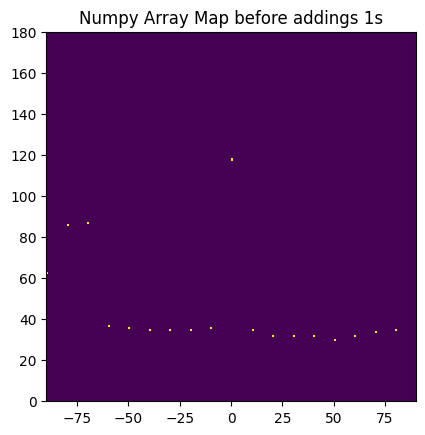

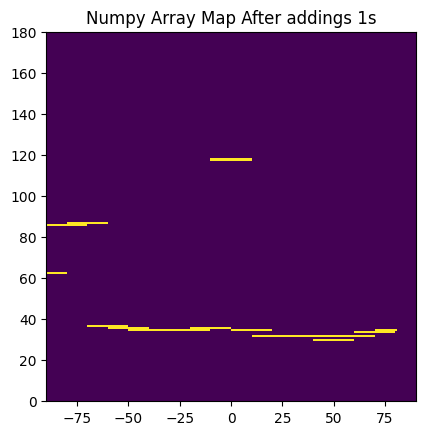

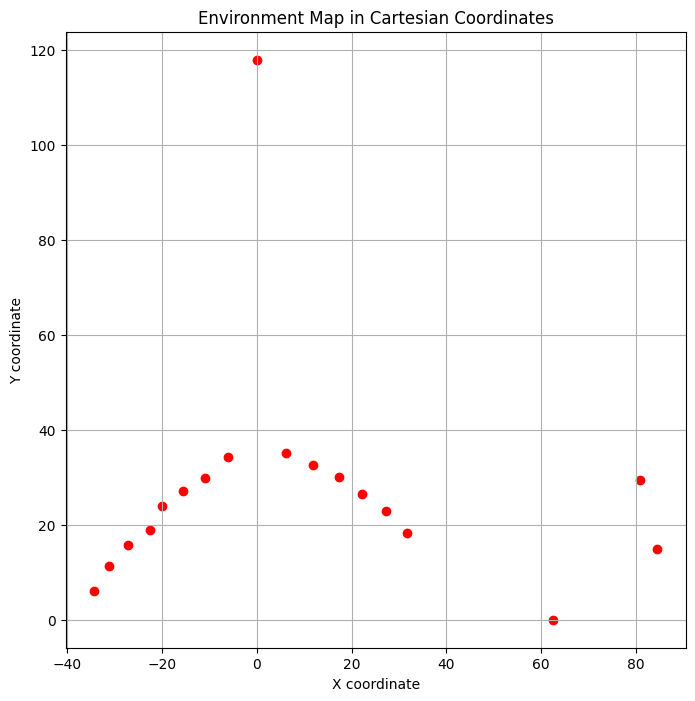

In [54]:
#!/usr/bin/env python
"""
Measures distance from Ultrasonic sensor then builds a 2D map. Plots the map to the
screen. In order to display plot on raspberry pi execute in shell. Using VNC 
viewer with the PI you can see the plots on the screen.
export DISPLAY=:0.0
"""

import numpy as np
import copy
from picar_4wd.pwm import PWM
from picar_4wd.filedb import FileDB
from picar_4wd.servo import Servo
from picar_4wd.ultrasonic import Ultrasonic
from picar_4wd.pin import Pin
import time
import matplotlib.pyplot as plt
import picar_4wd as fc


# Size of 2D Numpy Array
NP_ARRAY_SIZE = 180

# If below the threshold connect the coordinates
THRESHOLD = 10

SERVO_STEP = 10

# Maximum number of distance trials when -2 is returned
MAX_DISTANCE_READINGS = 3

# Config File:
config = FileDB()
ultrasonic_servo_offset = int(config.get("ultrasonic_servo_offset", default_value=0))

us = Ultrasonic(Pin("D8"), Pin("D9"))


servo = Servo(PWM("P0"), offset=ultrasonic_servo_offset)


def move_servo(angle):
    servo.set_angle(angle)
    time.sleep(0.3)


def get_distance():
    number_distance_readings = 0
    while number_distance_readings < MAX_DISTANCE_READINGS:
        distance = us.get_distance()
        if distance != -2:
            break
        number_distance_readings += 1
    return distance


def create_map(sensor_readings: list) -> list:
    """
    add 1s from the initial readings
    """
    x = NP_ARRAY_SIZE
    y = NP_ARRAY_SIZE
    a = np.zeros(shape=(x, y))
    for sensor_reading in sensor_readings:
        angle = int(sensor_reading["angle"])
        distance = int(sensor_reading["distance"])
        a[distance][angle + 90] = 1
    return a


def calculate_slope(x1, x2, y1, y2):
    slope = (y2 - y1) / (x2 - x1)
    return slope


def filter_below_threshold(sensor_readings: list) -> list:
    below_threshold = []
    for i in range(0, len(sensor_readings) - 1):
        reading1 = sensor_readings[i]
        reading2 = sensor_readings[i + 1]
        x1 = reading1["angle"]
        y1 = reading1["distance"]
        x2 = reading2["angle"]
        y2 = reading2["distance"]
        slope = calculate_slope(x1, x2, y1, y2)
        if abs(slope) < THRESHOLD:
            if reading1 not in below_threshold:
                below_threshold.append(reading1)
            below_threshold.append(reading2)
    return below_threshold


def add_ones(sensor_readings: list, numpy_array_map: list) -> list:
    """
    add 1s from the initial readings
    """
    numpy_array_ones_added = copy.deepcopy(numpy_array_map)
    for i in range(0, len(sensor_readings) - 1):
        angle1 = int(sensor_readings[i]["angle"])
        distance1 = int(sensor_readings[i]["distance"])
        angle2 = int(sensor_readings[i + 1]["angle"])
        distance2 = int(sensor_readings[i + 1]["distance"])
        numpy_array_ones_added[distance1][angle1 + 90 : angle2 + 90] = 1
        numpy_array_ones_added[distance2][angle1 + 90 : angle2 + 90] = 1
    return numpy_array_ones_added


def get_sensor_readings():
    sensor_readings = []
    for i in range(0, 180, SERVO_STEP):
        angle = i - 90
        move_servo(angle)
        distance = get_distance()
        if distance == -2:
            distance = 179
        if distance > 0 and distance < 180:
            sensor_readings.append({"angle": angle, "distance": distance})
    return sensor_readings


def create_matplot_lib_map(numpy_array_map, numpy_array_ones_added):
    x_min, x_max = -90, 90
    y_min, y_max = 0, 180
    extent = [x_min, x_max, y_min, y_max]

    # matplotlib before 1s added
    plt.title("Numpy Array Map before addings 1s")
    plt.imshow(numpy_array_map, interpolation="none", extent=extent, origin="lower")
    plt.show()

    # matplot lib after 1s added
    plt.title("Numpy Array Map After addings 1s")
    plt.imshow(
        numpy_array_ones_added, interpolation="none", extent=extent, origin="lower"
    )
    plt.show()


def main():
    servo.set_angle(0)
    sensor_readings = get_sensor_readings()
    print(sensor_readings)
    numpy_array_map = create_map(sensor_readings)
    below_threshold_sensor_readings = filter_below_threshold(sensor_readings)
    numpy_array_ones_added = add_ones(below_threshold_sensor_readings, numpy_array_map)
    create_matplot_lib_map(numpy_array_map, numpy_array_ones_added)
    plot_cartesian_map(sensor_readings)
    servo.set_angle(0)


if __name__ == "__main__":
    main()

In [19]:
def polar_to_cartesian(r, theta_degrees):
    # Convert angle from degrees to radians
    theta_radians = np.deg2rad(theta_degrees)
    # Calculate Cartesian coordinates
    x = r * np.cos(theta_radians)
    y = r * np.sin(theta_radians)
    return x, y

def plot_cartesian_map(sensor_readings):
    # Initialize lists to store Cartesian coordinates
    x_coords = []
    y_coords = []
    
    # Convert each sensor reading to Cartesian coordinates and store
    for reading in sensor_readings:
        angle = reading["angle"] + 90
        distance = reading["distance"]
        if distance < 180:  # Avoid plotting out of range values
            x, y = polar_to_cartesian(distance, angle)
            x_coords.append(x)
            y_coords.append(y)
    
    # Plotting
    plt.figure(figsize=(8, 8))
    plt.scatter(x_coords, y_coords, c='red', marker='o')
    plt.title("Environment Map in Cartesian Coordinates")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.axis('equal')  # Ensure equal scaling for both axes
    plt.grid(True)
    plt.show()


In [39]:
import numpy as np
import copy
from picar_4wd.pwm import PWM
from picar_4wd.filedb import FileDB
from picar_4wd.servo import Servo
from picar_4wd.ultrasonic import Ultrasonic
from picar_4wd.pin import Pin
import time
import matplotlib.pyplot as plt
import picar_4wd as fc

# Size of 2D Numpy Array
NP_ARRAY_SIZE = 180

# If below the threshold connect the coordinates
THRESHOLD = 1



# Maximum number of distance trials when -2 is returned
MAX_DISTANCE_READINGS = 3

# Config File:
config = FileDB()
ultrasonic_servo_offset = int(config.get("ultrasonic_servo_offset", default_value=0))

us = Ultrasonic(Pin("D8"), Pin("D9"))


servo = Servo(PWM("P0"), offset=ultrasonic_servo_offset)



In [55]:
def main():
    SERVO_STEP = 5
    servo.set_angle(-90)
    x_val = []
    y_val = []
    for i in range(-90, 95, SERVO_STEP):
        dist = fc.get_distance_at(i)
        x_va = -dist*np.sin(np.radians(i))
        y_va = dist*np.cos(np.radians(i))
        if abs(x_va) > 50 or abs(y_va) > 50:
            continue
        x_val.append(x_va)
        y_val.append(y_va)
        
    plt.scatter(x_val, y_val)
    plt.xlim(-60, 60)
    plt.ylim(0, 60)
    print(x_val, y_val)
    plt.show()
    servo.set_angle(-90)

[35.1, 34.53807018284082, 31.999638669835008, 29.538622717061045, 27.278842619466808, 24.833590155271544, 22.298302180026045, 19.874423519563745, 17.344999999999995, 14.669079865019677, 11.857838369100936, 9.079372102196427, 6.0933145543325855, -3.043478536748223, -6.05511195524586, -8.913727913330813, -11.337967751245918, -13.439260723354243, -15.649999999999999, -17.94147092906072, -19.290056166693045, -21.191990232160826, -22.966012404706962, -24.525412206012415, -27.08927463037724, -28.313055267024943, -30.61518558520489, -31.981804108431053, -33.877386703619955, -34.78711885736376, -34.91] [2.149255132503605e-15, 3.0216896010613077, 18.475000000000005, 20.683166294818726, 22.889666780937667, 24.833590155271548, 26.574081731797346, 28.383618334613566, 30.042421257282175, 31.45794328804212, 32.57914316264745, 33.88467798622052, 34.55690405319838, 34.78711885736376, 34.34024634753569, 33.26648545739551, 31.150810379052864, 28.82058762776547, 27.10659513845293, 25.623075945359666, 22.

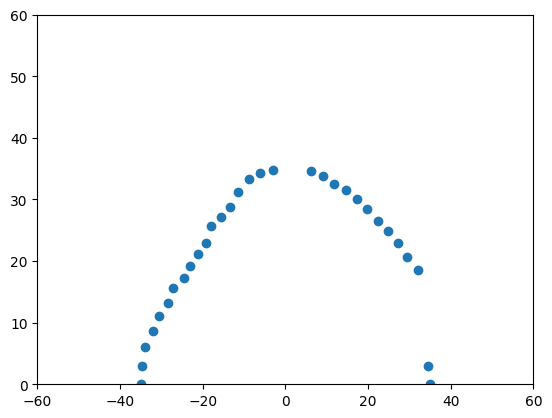

In [56]:
main()

### Version 3

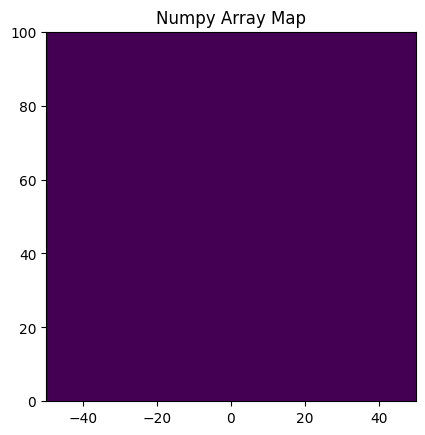

43 36
11 11
8 10
8 12
7 13
5 12
4 11
3 11
2 10
1 10
0 10
-1 11
-2 11
-3 11
-4 12
-16 35
-7 13


/tmp/ipykernel_1290/3120548641.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  slope = diff_coord[1] / diff_coord[0]


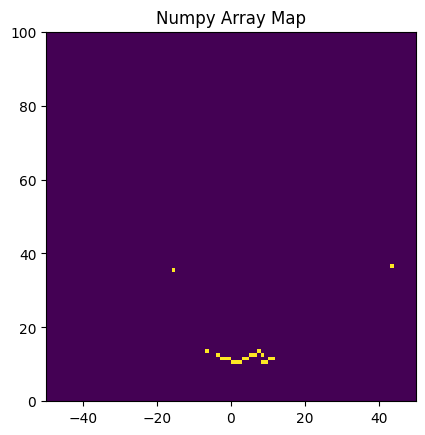

In [6]:
import numpy as np
import copy
from picar_4wd.pwm import PWM
from picar_4wd.filedb import FileDB
from picar_4wd.servo import Servo
from picar_4wd.ultrasonic import Ultrasonic
from picar_4wd.pin import Pin
import time
import matplotlib.pyplot as plt
import picar_4wd as fc

# Size of 2D Numpy Array
NP_ARRAY_SIZE = 100

# If below the threshold connect the coordinates
THRESHOLD = 1

SERVO_STEP = 5

# Maximum number of distance trials when -2 is returned
MAX_DISTANCE_READINGS = 3

global TURN_SPEED

TURN_SPEED = 30

# Config File:
config = FileDB()
ultrasonic_servo_offset = int(config.get("ultrasonic_servo_offset", default_value=0))

us = Ultrasonic(Pin("D8"), Pin("D9"))


servo = Servo(PWM("P0"), offset=ultrasonic_servo_offset)

global ENV_MAP

ENV_MAP = np.zeros((NP_ARRAY_SIZE, NP_ARRAY_SIZE))

def get_distance():
    number_distance_readings = 0
    while number_distance_readings < MAX_DISTANCE_READINGS:
        distance = us.get_distance()
        if distance != -2:
            break
        number_distance_readings += 1
    return distance


def get_dergee_distance():
    
    degree_distance_list = []
    for degree in range(-70, 75, SERVO_STEP):
        servo.set_angle(degree)
        time.sleep(0.3)
        distance = get_distance()
        degree_distance_list.append((degree, distance))
        
    return degree_distance_list

def init_map(degree_distance_list: list) -> list:
    
    global ENV_MAP

    ENV_MAP = np.zeros((NP_ARRAY_SIZE, NP_ARRAY_SIZE))
    
    prev_coord = np.array([-100000, -100000])
    
    for degree, distance in degree_distance_list:
        
        x_val = round(distance*np.cos(np.radians(degree + 90)))
        y_val = round(distance*np.sin(np.radians(degree + 90)))
        
        if abs(x_val) >= 50 or y_val >= 50 or y_val <= 0:
            continue
            
        ENV_MAP[y_val][x_val + 50] = 1
        print(x_val, y_val)
        
        present_coord = np.array([x_val, y_val])
        relative_distance = calculate_distance(prev_coord, present_coord)
        
        if relative_distance <= 4:
            interpolate_map(prev_coord, present_coord)
            
        prev_coord = present_coord
        

def calculate_distance(prev_coord, present_coord):
    return np.linalg.norm(prev_coord - present_coord)
        
def interpolate_map(prev_coord, present_coord):
    diff_coord = prev_coord - present_coord
    slope = diff_coord[1] / diff_coord[0]
    for x in range(min(present_coord[0], prev_coord[0]) + 1, max(present_coord[0], prev_coord[0])):
        y = round(slope * (x - present_coord[0]) + present_coord[1])
        ENV_MAP[y][x + 50] = 1
    
def plot_map():
    x_min, x_max = -50, 50
    y_min, y_max = 0, 100
    extent = [x_min, x_max, y_min, y_max]

    plt.title("Numpy Array Map")
    plt.imshow(ENV_MAP, interpolation="none", extent=extent, origin="lower")
    plt.show()


def path_clear():
    return not ENV_MAP[:, 48:53].any()

def main():


    # degree_distance_list = get_dergee_distance()
    # init_map(degree_distance_list)
    # plot_map()
    # servo.set_angle(0)

    global TURN_SPEED
    run_duration = 30
    turn_time = 1.1
    

    start_time = time.time()
    
    while True:
        
        current_time = time.time()
        fc.stop()

        if current_time - start_time > run_duration:
            break

        degree_distance_list = get_dergee_distance()
        init_map(degree_distance_list)
        plot_map()
        servo.set_angle(0)
            
        if path_clear():
            fc.backward(20)
            time.sleep(2)
        else:
            fc.forward(TURN_SPEED)
            time.sleep(0.13)
            
            fc.turn_left(TURN_SPEED)
            time.sleep(turn_time)
            fc.stop()
            time.sleep(0.2)
            fc.backward(TURN_SPEED)
            time.sleep(turn_time)
            fc.stop()
            time.sleep(0.2)
            fc.turn_right(TURN_SPEED)
            time.sleep(turn_time)
            fc.stop()
            time.sleep(0.2)
            fc.backward(TURN_SPEED)
            time.sleep(1.3)
            fc.stop()
            time.sleep(0.2)
            fc.turn_right(TURN_SPEED)
            time.sleep(1.1)
            fc.stop()
            time.sleep(0.2)
            fc.backward(TURN_SPEED)
            time.sleep(1.5)
            fc.stop()
            time.sleep(0.2)
            fc.turn_left(TURN_SPEED)
            time.sleep(1)
            fc.stop()
            time.sleep(0.2)
            fc.backward(TURN_SPEED)
            time.sleep(1)
            
    
    
    
if __name__ == "__main__":
    main()